In [1]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)
import pandas as pd
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [2]:
import pickle as pkl
tt_sen1 = pkl.load(open("tt_sen1.p", "rb"))
tt_sen2 = pkl.load(open("tt_sen2.p", "rb"))
tv_sen1 = pkl.load(open("tv_sen1.p", "rb"))
tv_sen2 = pkl.load(open("tv_sen2.p", "rb"))
train_targets = pkl.load(open("train_targets.p", "rb"))
val_targets = pkl.load(open("val_targets.p", "rb"))

In [3]:
words_to_load = 50000

import numpy as np

with open('wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i, :] = np.asarray(s[1:])
        words_ft[s[0]] = i
        idx2words_ft[i] = s[0]
        ordered_words_ft.append(s[0])

In [4]:
#id2token
x=idx2words_ft
#token2idx
y=words_ft

In [5]:
idx2words_ft={}
idx2words_ft[0]='<pad>'
idx2words_ft[1]='<unk>'
for i in range(0,50000):
    idx2words_ft[i+2]=x[i]

In [6]:
w=list(words_ft.keys())
words_ft={}
words_ft['<pad>']=0
words_ft['<unk>']=1
for i in range(0,50000):
    words_ft[w[i]]=i+2

In [7]:
z=loaded_embeddings_ft

In [8]:
loaded_embeddings_ft=np.zeros(300)

In [9]:
loaded_embeddings_ft=np.vstack([loaded_embeddings_ft,np.ones(300)])

In [10]:
loaded_embeddings_ft=np.vstack([loaded_embeddings_ft,z])

In [11]:
token2id=words_ft

In [12]:
id2token=list(idx2words_ft.values())

In [13]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):  #REplaces each token with respective index
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices1 = token2index_dataset(tt_sen1)
train_data_indices2 = token2index_dataset(tt_sen2)
val_data_indices1 = token2index_dataset(tv_sen1)
val_data_indices2 = token2index_dataset(tv_sen2)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices1)))
print ("Train dataset size is {}".format(len(train_data_indices2)))
print ("Val dataset size is {}".format(len(val_data_indices1)))
print ("Val dataset size is {}".format(len(val_data_indices2)))

Train dataset size is 100000
Train dataset size is 100000
Val dataset size is 1000
Val dataset size is 1000


In [14]:
mm=0
for i in range(0,100000):
    r=max(len(train_data_indices1[i]),len(train_data_indices2[i]))
    if mm<r:
        mm=r

In [15]:
mm

82

In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """    
    def __init__(self, data_list1,data_list2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.target_list))
        assert (len(self.data_list2) == len(self.target_list))
        assert (len(self.data_list1) == len(self.data_list2))
    def __len__(self):
        assert (len(self.data_list1) == len(self.data_list2))
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH]       
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1),token_idx2, len(token_idx2), label]

In [17]:
MAX_SENTENCE_LENGTH = mm
#MAX_SENTENCE_LENGTH is a hyperparameter
#We implement dataset first before data loader. It takes 2 things as input.
#Datatlist (dataset converted to indices of tokens)
#Targetlist ( number between 1-20 that represents the target of document)
#We need to implement len and getitem

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """    
    def __init__(self, data_list1,data_list2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.target_list))
        assert (len(self.data_list2) == len(self.target_list))
        assert (len(self.data_list1) == len(self.data_list2))
    def __len__(self):
        assert (len(self.data_list1) == len(self.data_list2))
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH]       
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1),token_idx2, len(token_idx2), label]
#Collate function adds padding symbols to data in case its smaller than
# the max sentence length
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    length_list1 = []
    data_list2 = []
    length_list2 = []
    label_list = []

    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[1])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[2]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
        
    ind_dec_order1 = np.argsort(length_list1)[::-1]
    ind_dec_order2 = np.argsort(length_list2)[::-1]
    
    data_list1 = np.array(data_list1)[ind_dec_order1]
    data_list2 = np.array(data_list2)[ind_dec_order2]
    
    length_list1 = np.array(length_list1)[ind_dec_order1]
    length_list2 = np.array(length_list2)[ind_dec_order2]
    
#     label_list = np.array(label_list)[ind_dec_order]    
        
    return [torch.from_numpy(np.array(data_list1)), torch.from_numpy(np.array(np.int32(length_list1))) ,torch.from_numpy(np.array(data_list2)), torch.from_numpy(np.array(np.int32(length_list2))), torch.from_numpy(np.array(np.int32(label_list))).long(),ind_dec_order1,ind_dec_order2]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)
#train_dataset is a hyperparameter and also batchsize
#train and validation also has shuffling here
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices1, train_data_indices2, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


val_dataset = NewsGroupDataset(val_data_indices1, val_data_indices2, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

### Now lets implement basic Convolutional Neural Net model for text


In [18]:
weight = torch.FloatTensor(loaded_embeddings_ft)

In [19]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(weight,freeze=True)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(2*hidden_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        return hidden

    def forward(self, x1, lengths1, x2, lengths2,id1,id2):
        # reset hidden state

        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        
        self.hidden1 = self.init_hidden(batch_size1)
        self.hidden2 = self.init_hidden(batch_size2)
        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        # pack padded sequence
        #Pytorch wants sequences to be in descending order. First one have longest length and
        #Then the subsequent ones have lesser lengths
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, lengths1.numpy(), batch_first=True)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, lengths2.numpy(), batch_first=True)
        
        # fprop though RNN
        rnn_out1, self.hidden1 = self.rnn(embed1, self.hidden1)
        rnn_out2, self.hidden2 = self.rnn(embed2, self.hidden2)
        
        # undo packing
        rnn_out1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
        rnn_out2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)

        # sum hidden activations of RNN across time
        rnn_out1 = torch.sum(rnn_out1, dim=1)
        rnn_out2 = torch.sum(rnn_out2, dim=1)
        

        r1=rnn_out1.clone()
        r2=rnn_out2.clone()
        for i in range(0,len(r1)):
            rnn_out1[i]=r1[id1[i]]
        for i in range(0,len(r2)):
            rnn_out2[i]=r2[id2[i]]
        rnnoutfinal = torch.cat((rnn_out1, rnn_out2), 1)

        logits = self.linear(rnnoutfinal)
        return logits



In [20]:
pl=[]
pa=[]
epl=[]
epa=[]
llist=[]
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, lengths1,data2, lengths2, labels,id1,id2 in loader:
        data_batch1, lengths_batch1,data_batch2, lengths_batch2, label_batch,idd1,idd2 = data1, lengths1,data2, lengths2, labels,id1,id2
        outputs = F.softmax(model(data_batch1, lengths_batch1,data_batch2, lengths_batch2,idd1,idd2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        llist.append([data1,data2,labels,predicted])
    return (100 * correct / total)


model = RNN(emb_size=300, hidden_size=200, num_layers=2, num_classes=3, vocab_size=50002)

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    l=0
    a=0
    c=0
    for i, (data1, lengths1,data2, lengths2, labels,id1,id2) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1, lengths1,data2, lengths2,id1,id2)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            
            val_acc = test_model(val_loader, model) 
            c=c+1
            l=l+loss.item()
            a=a+val_acc
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            pa.append(val_acc)
            pl.append(loss.item())
    epl.append(l/c)
    epa.append(a/c)


Epoch: [1/10], Step: [101/3125], Validation Acc: 54.6
Epoch: [1/10], Step: [201/3125], Validation Acc: 53.2
Epoch: [1/10], Step: [301/3125], Validation Acc: 53.4
Epoch: [1/10], Step: [401/3125], Validation Acc: 50.0
Epoch: [1/10], Step: [501/3125], Validation Acc: 53.2
Epoch: [1/10], Step: [601/3125], Validation Acc: 56.5
Epoch: [1/10], Step: [701/3125], Validation Acc: 53.5
Epoch: [1/10], Step: [801/3125], Validation Acc: 50.6
Epoch: [1/10], Step: [901/3125], Validation Acc: 53.4
Epoch: [1/10], Step: [1001/3125], Validation Acc: 52.8
Epoch: [1/10], Step: [1101/3125], Validation Acc: 53.1
Epoch: [1/10], Step: [1201/3125], Validation Acc: 52.5
Epoch: [1/10], Step: [1301/3125], Validation Acc: 50.0
Epoch: [1/10], Step: [1401/3125], Validation Acc: 51.3
Epoch: [1/10], Step: [1501/3125], Validation Acc: 53.6
Epoch: [1/10], Step: [1601/3125], Validation Acc: 53.5
Epoch: [1/10], Step: [1701/3125], Validation Acc: 56.0
Epoch: [1/10], Step: [1801/3125], Validation Acc: 53.6
Epoch: [1/10], Step

Epoch: [5/10], Step: [2701/3125], Validation Acc: 54.5
Epoch: [5/10], Step: [2801/3125], Validation Acc: 53.2
Epoch: [5/10], Step: [2901/3125], Validation Acc: 54.7
Epoch: [5/10], Step: [3001/3125], Validation Acc: 52.1
Epoch: [5/10], Step: [3101/3125], Validation Acc: 52.4
Epoch: [6/10], Step: [101/3125], Validation Acc: 54.2
Epoch: [6/10], Step: [201/3125], Validation Acc: 52.7
Epoch: [6/10], Step: [301/3125], Validation Acc: 52.8
Epoch: [6/10], Step: [401/3125], Validation Acc: 54.1
Epoch: [6/10], Step: [501/3125], Validation Acc: 52.3
Epoch: [6/10], Step: [601/3125], Validation Acc: 50.4
Epoch: [6/10], Step: [701/3125], Validation Acc: 55.0
Epoch: [6/10], Step: [801/3125], Validation Acc: 55.7
Epoch: [6/10], Step: [901/3125], Validation Acc: 52.5
Epoch: [6/10], Step: [1001/3125], Validation Acc: 51.7
Epoch: [6/10], Step: [1101/3125], Validation Acc: 51.3
Epoch: [6/10], Step: [1201/3125], Validation Acc: 54.2
Epoch: [6/10], Step: [1301/3125], Validation Acc: 51.8
Epoch: [6/10], Step

Epoch: [10/10], Step: [2201/3125], Validation Acc: 54.6
Epoch: [10/10], Step: [2301/3125], Validation Acc: 52.8
Epoch: [10/10], Step: [2401/3125], Validation Acc: 54.9
Epoch: [10/10], Step: [2501/3125], Validation Acc: 54.0
Epoch: [10/10], Step: [2601/3125], Validation Acc: 52.7
Epoch: [10/10], Step: [2701/3125], Validation Acc: 53.7
Epoch: [10/10], Step: [2801/3125], Validation Acc: 54.2
Epoch: [10/10], Step: [2901/3125], Validation Acc: 49.5
Epoch: [10/10], Step: [3001/3125], Validation Acc: 52.2
Epoch: [10/10], Step: [3101/3125], Validation Acc: 51.1


In [21]:
epa

[53.55161290322581,
 53.50000000000001,
 53.090322580645164,
 53.98387096774194,
 53.09032258064515,
 53.21935483870968,
 53.6741935483871,
 53.40000000000001,
 53.493548387096766,
 53.4967741935484]

In [22]:
epl

[1.1114383166836155,
 1.1034220649350075,
 1.1028071872649654,
 1.1062310164974583,
 1.106403689230642,
 1.1078952550888062,
 1.104857314017511,
 1.1048616709247712,
 1.102532413698012,
 1.1045335185143255]

In [38]:
epa1=[53.55161290322581,
 53.50000000000001,
 53.090322580645164,
 53.98387096774194,
 53.09032258064515,
 53.21935483870968]
epa2=[53.606451612903214,
 53.56774193548387,
 53.319354838709685,
 53.309677419354834,
 53.20967741935483,
 52.93548387096775]
epa3=[53.14193548387098,
 53.274193548387096,
 53.18387096774193,
 53.73548387096775,
 52.770967741935486,
 53.10967741935484]
epa4=[53.41290322580647,
 53.42903225806451,
 53.270967741935486,
 53.04516129032257,
 53.39354838709678,
 53.21935483870967]
epa5=[53.322580645161274,
 53.551612903225816,
 53.125806451612895,
 53.529032258064504,
 53.58064516129032,
 53.57096774193548]
epa11=[52.929032258064524,
 53.087096774193554,
 53.75483870967743,
 53.6,
 53.57419354838709,
 53.696774193548386,
 ]
epa22=[53.44516129032258,
 53.30645161290322,
 53.50645161290324,
 53.00322580645162,
 53.10645161290322,
 53.1516129032258]
epa33=[53.50322580645161,
 53.29032258064516,
 53.43870967741935,
 53.62903225806452,
 53.29677419354839,
 53.4]
epa44=[53.354838709677416,
 53.070967741935476,
 53.46129032258064,
 53.319354838709664,
 53.09354838709676,
 53.109677419354846]
epa55=[53.522580645161284,
 52.97096774193548,
 53.54516129032257,
 53.59354838709678,
 53.34516129032259,
 53.50000000000001]
epo=range(1,7)

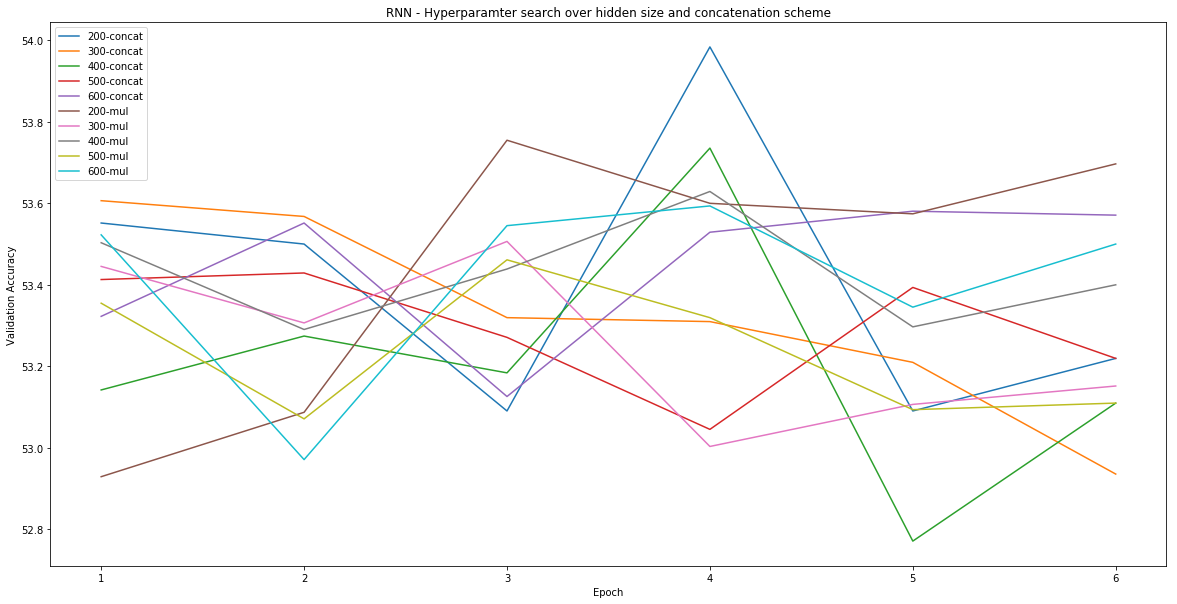

In [39]:
xx=epo
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,10))
plt.plot(xx,epa1,label='200-concat')
plt.plot(xx,epa2,label='300-concat')
plt.plot(xx,epa3,label='400-concat')
plt.plot(xx,epa4,label='500-concat')
plt.plot(xx,epa5,label='600-concat')
plt.plot(xx,epa11,label='200-mul')
plt.plot(xx,epa22,label='300-mul')
plt.plot(xx,epa33,label='400-mul')
plt.plot(xx,epa44,label='500-mul')
plt.plot(xx,epa55,label='600-mul')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('RNN - Hyperparamter search over hidden size and concatenation scheme')
plt.show()

In [45]:
epl1=[1.1114383166836155,
 1.1034220649350075,
 1.1028071872649654,
 1.1062310164974583,
 1.106403689230642,
 1.1078952550888062]
epl2=[1.1213771643177155,
 1.1042435515311457,
 1.1063944678152762,
 1.0960471630096436,
 1.1129404383320962,
 1.1130090144372755]
epl3=[1.1113098936696206,
 1.1075533820736794,
 1.1144828950205157,
 1.115535520738171,
 1.110246692934344,
 1.1154065632051038]
epl4=[1.1222433082519039,
 1.107956470981721,
 1.1295858467778852,
 1.1131312001136042,
 1.1107653494804137,
 1.11694928907579]
epl5=[1.1166780071873819,
 1.1196106864560036,
 1.134607184317804,
 1.1322986041345904,
 1.128976425816936,
 1.1235411513236262]
epl11=[1.1132340162031111,
 1.098902959977427,
 1.102865949753792,
 1.1011739623162053,
 1.1042430708485265,
 1.1002516938794045]
epl22=[1.1017755693004978,
 1.1065165035186275,
 1.1044328712647962,
 1.1025771402543592,
 1.1072562240785169,
 1.0978969989284393]
epl33=[1.1072262525558472,
 1.1019065187823387,
 1.107035921465966,
 1.1060509374064784,
 1.1166655978848856,
 1.1001729119208552]
epl44=[1.1082172163071171,
 1.105687564419162,
 1.1171741639414141,
 1.1088292483360536,
 1.1070284074352634,
 1.109632549747344]
epl55=[1.102874586659093,
 1.1036340536609772,
 1.105860721680426,
 1.107954659769612,
 1.0985853018299225,
 1.1076324370599562]

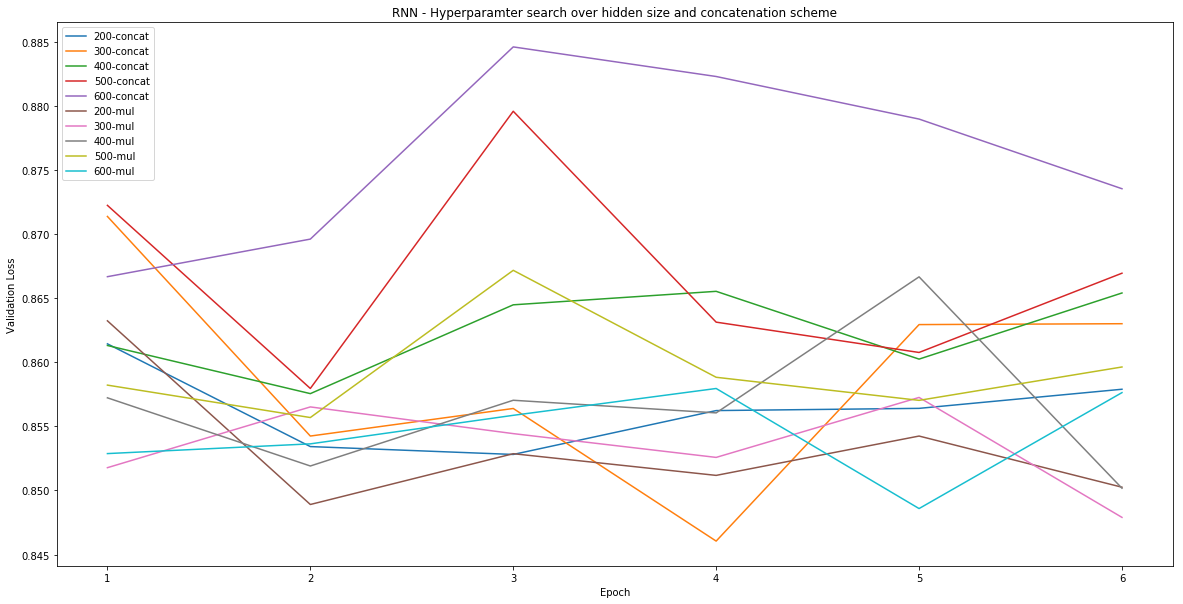

In [64]:
xx=epo
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,10))
plt.plot(xx,epl1,label='200-concat')
plt.plot(xx,epl2,label='300-concat')
plt.plot(xx,epl3,label='400-concat')
plt.plot(xx,epl4,label='500-concat')
plt.plot(xx,epl5,label='600-concat')
plt.plot(xx,epl11,label='200-mul')
plt.plot(xx,epl22,label='300-mul')
plt.plot(xx,epl33,label='400-mul')
plt.plot(xx,epl44,label='500-mul')
plt.plot(xx,epl55,label='600-mul')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('RNN - Hyperparamter search over hidden size and concatenation scheme')
plt.show()